<a href="https://colab.research.google.com/github/Ruchitha201/ML_Project_Team13/blob/main/classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from sklearn.base import BaseEstimator, TransformerMixin
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, roc_auc_score, f1_score
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn import metrics
import warnings
import dlib
import cv2

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/totalmaindata.csv',sep=',')
participants = set(df.Participant)
df = df.drop(["Participant"], axis=1)
df = df[df.Y != 5.0]  # form a binary problem, delete the 5.0 ones
df.loc[df.Y == 0.0, "Y"] = int(0)
df.loc[df.Y == 10.0, "Y"] = int(1)

train_percentage = 14/18 # based on max uniq. participants
train_samples = int(len(df) * train_percentage)
test_samples = len(df) - train_samples

df_train = df[:train_samples]
df_test = df[-test_samples:]

X_test = df_test.drop(["Y"], axis=1)
y_test = df_test["Y"]

X_train = df_train.drop('Y', axis=1)
y_train = df_train['Y']
print(f'X_test: {X_test.shape} \ny_test: {y_test.shape} \nX_train: {X_train.shape} \ny_train: {y_train.shape}')
df_train

X_test: (1920, 8) 
y_test: (1920,) 
X_train: (6720, 8) 
y_train: (6720,)


,Y,MOE,EAR,MAR,Circularity,EAR_N,MAR_N,Circularity_N,MOE_N
0,0,2.534145,0.312688,0.792397,0.432896,-0.999551,0.802437,-0.948848,0.877172
1,0,2.379947,0.321940,0.766199,0.486923,-0.000897,0.317858,1.044306,0.211742
2,0,2.078550,0.331216,0.688449,0.456029,1.000448,-1.120295,-0.095458,-1.088914
3,0,2.509767,0.309246,0.776136,0.452655,-1.371052,0.501666,-0.219920,0.771970
4,0,3.586821,0.204691,0.734189,0.361123,-12.657205,-0.274242,-3.596686,5.419921
...,...,...,...,...,...,...,...,...,...
9595,1,3.516036,0.308254,1.083833,0.440628,-3.087456,3.700493,-1.776452,4.040717
9596,1,3.585545,0.301381,1.080614,0.447949,-3.694883,3.646635,-1.472575,4.322363
9597,1,3.750118,0.286855,1.075740,0.450278,-4.978551,3.565087,-1.375905,4.989206
9598,1,4.123695,0.260188,1.072936,0.403545,-7.335156,3.518178,-3.315660,6.502924


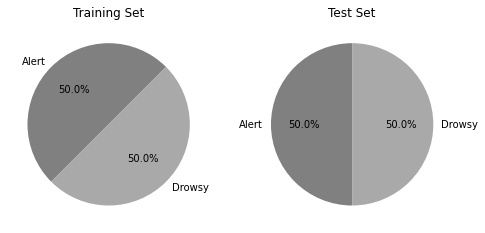

In [ ]:
label = 'Alert', 'Drowsy'
plt.figure(figsize = (8,8))
plt.subplot(121)
plt.title("Training Set")
plt.pie(df_train.groupby('Y').size(), labels = label, autopct='%1.1f%%', startangle=45, colors={"grey", "darkgrey"})
plt.subplot(122)
plt.title("Test Set")
plt.pie(df_test.groupby('Y').size(), labels = label, autopct='%1.1f%%', startangle=90, colors={"grey", "darkgrey"})
plt.show()

In [ ]:
#KNN classifier
def average(y_pred):
    """Averaging sequential frames for classifier"""
    for i in range(len(y_pred)-1):
        if i % 240 == 0 or (i+1) % 240 == 0:
            pass
        else: 
            average = float(y_pred[i-1] + y_pred[i] + y_pred[i+1])/3
            if average >= 0.5:
                y_pred[i] = 1
            else:
                y_pred[i] = 0
    return y_pred

acc3_list = []
f1_score3_list = []
roc_3_list = []

# take 45 runs and save best one
for i in range(1, 45):
    neigh = KNeighborsClassifier(n_neighbors=i)
    neigh.fit(X_train, y_train) 
    pred_KN = neigh.predict(X_test)
    pred_KN = average(pred_KN)
    y_score_3 = neigh.predict_proba(X_test)[:,1]
    acc3_list.append(accuracy_score(y_test, pred_KN))
    f1_score3_list.append(metrics.f1_score(y_test, pred_KN))
    roc_3_list.append(metrics.roc_auc_score(y_test, y_score_3))
    
neigh = KNeighborsClassifier(n_neighbors=acc3_list.index(max(acc3_list))+1)
print(f"Neighbors: {neigh.get_params()['n_neighbors']}")
neigh.fit(X_train, y_train)
acc3 = accuracy_score(y_test, pred_KN)
print(acc3)

Neighbors: 38
0.6963541666666667


In [ ]:
def model_knn(landmarks):
    """Returns features and classification result"""
    features = pd.DataFrame(columns=["EAR","MAR","Circularity","MOE"])
    eye = landmarks[36:68] # Extracting relevant parts (eyes + mouth)
    ear = eye_aspect_ratio(eye)
    mar = mouth_aspect_ratio(eye)
    cir = circularity(eye)
    mouth_eye = mouth_over_eye(eye)
    df = features.append({"EAR":ear,"MAR": mar,"Circularity": cir,"MOE": mouth_eye},ignore_index=True)

    # Normalisation
    df["EAR_N"] = (df["EAR"] - mean["EAR"]) / std["EAR"]
    df["MAR_N"] = (df["MAR"] - mean["MAR"]) / std["MAR"]
    df["Circularity_N"] = (df["Circularity"] - mean["Circularity"]) / std["Circularity"]
    df["MOE_N"] = (df["MOE"] - mean["MOE"]) / std["MOE"]
    
    Result = neigh.predict(df)  
    if Result == 1:
        Result_String = "Drowsy"
        fontColor = (0, 0, 245)
    else:
        Result_String = "Alert"
        fontColor = (255, 255, 255)
    
    return Result_String, df.values, fontColor

In [ ]:
X_train_shaped = np.expand_dims(X_train, axis=2)

In [ ]:
X_train_shaped.shape

(6720, 8, 1)

In [ ]:
X_test_shaped = np.expand_dims(X_test, axis=2)

In [ ]:
X_test_shaped.shape

(1920, 8, 1)

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Flatten
from keras.layers.convolutional import Conv1D
from keras.optimizers import Adam, RMSprop
from keras.layers import Dropout
## Create Model ##

model = Sequential()

model.add(Conv1D(64, kernel_size = 3, activation = 'relu', input_shape = (8,1)))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(16, activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(1,activation = 'sigmoid'))


## Compile Model ##
optimizer = Adam(lr=0.00001)
model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

## Train Model and Check Validation Accuracy ##
model.fit(X_train_shaped, y_train, validation_data = (X_test_shaped,y_test), epochs = 100)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/100
210/210 [==============================] - 17s 5ms/step - loss: 0.7339 - accuracy: 0.5109 - val_loss: 0.6893 - val_accuracy: 0.5490
Epoch 2/100
210/210 [==============================] - 0s 2ms/step - loss: 0.6694 - accuracy: 0.5829 - val_loss: 0.6595 - val_accuracy: 0.6333
Epoch 3/100
210/210 [==============================] - 1s 3ms/step - loss: 0.6424 - accuracy: 0.6386 - val_loss: 0.6421 - val_accuracy: 0.7099
Epoch 4/100
210/210 [==============================] - 1s 2ms/step - loss: 0.6357 - accuracy: 0.6737 - val_loss: 0.6281 - val_accuracy: 0.7312
Epoch 5/100
210/210 [==============================] - 1s 3ms/step - loss: 0.6092 - accuracy: 0.6976 - val_loss: 0.6155 - val_accuracy: 0.7344
Epoch 6/100
210/210 [==============================] - 0s 2ms/step - loss: 0.6074 - accuracy: 0.7136 - val_loss: 0.6038 - val_accuracy: 0.7359
Epoch 7/100
210/210 [==============================] - 0s 2ms/step - loss: 0.5939 - accuracy: 0.7208 - val_loss: 0.5944 - val_accuracy: 0.732

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_2 (Conv1D)            (None, 6, 64)             256       
_________________________________________________________________
flatten_2 (Flatten)          (None, 384)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 32)                12320     
_________________________________________________________________
dense_7 (Dense)              (None, 16)                528       
_________________________________________________________________
dropout_2 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 17        
Total params: 13,121
Trainable params: 13,121
Non-trainable params: 0
__________________________________________________

In [ ]:
pred_cnn = model.predict_classes(X_test_shaped)
pred_cnn = average(pred_cnn)
y_score_7 = model.predict_proba(X_test_shaped)
acc7 = accuracy_score(y_test, np.array(pred_cnn))
f1_score_7 = metrics.f1_score(y_test, pred_cnn)
roc_7 = metrics.roc_auc_score(y_test, y_score_7)
print([acc7,f1_score_7,roc_7])
print(confusion_matrix(y_test, pred_cnn))

/usr/local/lib/python3.7/dist-packages/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[0.7192708333333333, 0.6520335700451905, 0.7617068142361111]
[[876  84]
 [455 505]]


/usr/local/lib/python3.7/dist-packages/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


,Accuracy
Model,
KNN,0.696354
CNN,0.719271


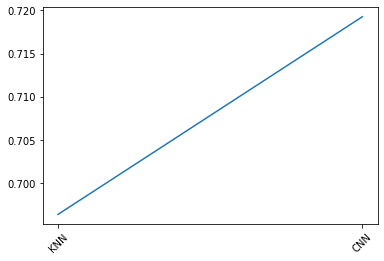

In [ ]:
acc_total = {'Model':['KNN' ,'CNN'],
        'Accuracy':[acc3,acc7]}
acc_total=pd.DataFrame(acc_total)
acc_total=acc_total.set_index('Model')
acc_total
plt.plot(acc_total['Accuracy'])
plt.xticks(rotation=45)
acc_total